This notebook analyzes the data for version 0 of the paper.

In [1]:
%matplotlib inline

In [2]:
from kid_readout.measurement.io import nc
from kid_readout.analysis.timeseries import binning

In [3]:
data_directory = '/data/readout/'

shield_files = ['2016-07-13_104209_magnetic_shield.nc',
                '2016-07-26_185334_magnetic_shield.nc']

ambient_files = ['2016-07-13_144753_ambient.nc',
                 '2016-07-13_160639_ambient.nc']

cool_155_data_155_file = '2016-07-20_141430_magnet_array.nc'
cool_155_data_85_file = '2016-07-20_155530_magnet_array.nc'
cool_85_data_85_file = '2016-07-20_191253_magnet_array.nc'
cool_85_data_155_file = '2016-07-20_204043_magnet_array.nc'

array_files = ['2016-07-14_125121_magnet_array.nc',  # 162 mm, up
               '2016-07-14_191847_magnet_array.nc',  # 65 mm, up
               '2016-07-15_001146_magnet_array.nc',  # 100 mm, up
               '2016-07-15_123235_magnet_array.nc',  # 120 mm, up
               '2016-07-15_165543_magnet_array.nc',  # 140 mm, up
               '2016-07-16_140542_magnet_array.nc',  # 150 mm, up
               '2016-07-18_135051_magnet_array.nc',  # 85 mm, up
               '2016-07-18_184047_magnet_array.nc',  # 130 mm, up; saved as 85 mm and retroactively fixed
               '2016-07-19_143115_magnet_array.nc',  # 145 mm, up
               '2016-07-19_200237_magnet_array.nc',  # 155 mm, up
               cool_155_data_155_file,
               cool_85_data_85_file,
               '2016-07-22_130630_magnet_array.nc',  # 65 mm, down
               '2016-07-22_173850_magnet_array.nc',  # 0 mm, up
               '2016-07-26_111004_magnet_array.nc',  # 0 mm, down
              ]

In [4]:
# This frequency was empirically determined
f_ptc = 1.412

# These values are pasted from the notebook that analyzes the magnetic array vs. distance data
up_offset = 8.6198539821769611
up_slope = 450592601.5250684
down_offset = -7.675890008999394
down_slope = -452796357.53515184

In [5]:
def magnet_field_uT(d_mm, orientation):
    if orientation == 1:
        return up_slope / d_mm**3 + up_offset
    elif orientation == -1:
        return down_slope / d_mm**3 + down_offset
    else:
        raise ValueError("Invalid orientation: {}".format(orientation))


def harmonic_mask(f, fundamental, num_harmonics, width):
    mask = np.ones(f.size, dtype=np.bool)
    for harmonic in range(1, num_harmonics + 1):
        indices = np.abs(f - fundamental * harmonic) < width
        mask[indices] = False
    return mask


def log_bin_noise_after_masking_harmonics(frequency, data, fundamental=f_ptc, num_harmonics=15, width=0.05):
    mask = harmonic_mask(f=frequency, fundamental=fundamental, num_harmonics=num_harmonics, width=width)
    frequency_masked = frequency[mask]
    data_masked = data[mask]
    log_bin_edges = binning.log_bin_edges(frequency_masked, bins_per_decade=30, ensure_none_empty=False)
    bin_indices = np.digitize(frequency_masked, log_bin_edges)
    frequency_binned = np.array([frequency_masked[bin_indices==n].mean() for n in range(1, bin_indices.size)])
    data_binned = np.array([data_masked[bin_indices==n].mean() for n in range(1, bin_indices.size)])
    nan_mask = np.logical_not(np.isnan(frequency_binned))
    return frequency_binned[nan_mask], data_binned[nan_mask]


def sss_to_series(sss, shield=False, ambient=False):
    series = sss.to_dataframe().iloc[0]

    # Calculate the magnetic field
    series['shield'] = shield
    series['ambient'] = ambient
    if shield:
        series['ambient_field_uT'] = 0
    else:
        series['ambient_field_uT'] = -30
    if shield or ambient:
        series['field_uT'] = series.ambient_field_uT
    else:
        if 'magnet_array_orientation' not in series:
            series['magnet_array_orientation'] = 1
        series['optical_plate_to_stage_top_mm'] = 335
        series['stage_top_to_chip_mm'] = 4.82
        series['jack_top_to_magnet_center_mm'] = 25.5 + 1.5
        series['magnet_distance_mm'] = (series.optical_plate_to_stage_top_mm + series.stage_top_to_chip_mm -
                                        (series.magnet_array_height_mm + series.jack_top_to_magnet_center_mm))
        series['magnet_field_uT'] = magnet_field_uT(series.magnet_distance_mm, series.magnet_array_orientation)
        series['field_uT'] = series.ambient_field_uT + series.magnet_field_uT
    
    # Calculate the noise spectra after masking pulse tube harmonics
    sss.set_S(detrend=plt.mlab.detrend_none, window=plt.mlab.window_hanning, binned=False, NFFT=sss.stream.s21_raw.size)
    S_frequency_masked_binned, S_xx_masked_binned = log_bin_noise_after_masking_harmonics(sss.S_frequency, sss.S_xx)
    series['S_frequency_masked_binned'] = S_frequency_masked_binned
    series['S_xx_masked_binned'] = S_xx_masked_binned
    return series

# Select, analyze, and save data

In [ ]:
attenuation = 41
numbers = [0, 1, 2]

file_names = [shield_files[1], ambient_files[1]] + array_files
node_names = len(file_names) * ['SweepStreamArray13']

for file_name, node_name in zip(file_names, node_names):
    print(file_name)
    ncf = nc.NCFile(data_directory + file_name)
    ssa = ncf.read(node_name)
    ncf.close()
    assert ssa.stream_array.roach_state.dac_attenuation == attenuation
    shield = 'magnetic_shield_bucket' in ssa.state
    ambient = not shield and 'magnet_array' not in ssa.state
    serieses = [sss_to_series(ssa[number], shield=shield, ambient=ambient) for number in numbers]
    df = pd.concat(serieses, axis=1, ignore_index=True).T
    npy_file_name = '{}_num_{}_atten_{}.npy'.format(file_name, '_'.join([str(number) for number in numbers]), attenuation)
    np.save(npy_file_name, df.to_records())

2016-07-26_185334_magnetic_shield.nc


/home/flanigan/miniconda2/envs/analysis/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


# Test

In [8]:
ncf = nc.NCFile(data_directory + array_files[0])
ssa = ncf.read('SweepStreamArray13')
serieses = [sss_to_series(ssa[channel_index], ambient=True) for channel_index in range(3)]

/home/flanigan/miniconda2/envs/analysis/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [9]:
df = pd.concat(serieses, axis=1, ignore_index=True).T
df.shape

(3, 66)

In [10]:
number = 1
s = df[df.number==number].iloc[0]

In [11]:
s.keys()

Index([                      u'S_frequency',
                                    u'S_xx',
                                    u'S_xy',
                                    u'S_yy',
                          u'analysis_epoch',
                  u'magnet_array_height_mm',
                                  u'number',
                               u'res_A_mag',
                         u'res_A_mag_error',
                             u'res_A_slope',
                       u'res_A_slope_error',
                                   u'res_Q',
                                 u'res_Q_e',
                            u'res_Q_e_imag',
                      u'res_Q_e_imag_error',
                            u'res_Q_e_real',
                      u'res_Q_e_real_error',
                             u'res_Q_error',
                                 u'res_Q_i',
                               u'res_delay',
                         u'res_delay_error',
                                 u'res_f_0',
          

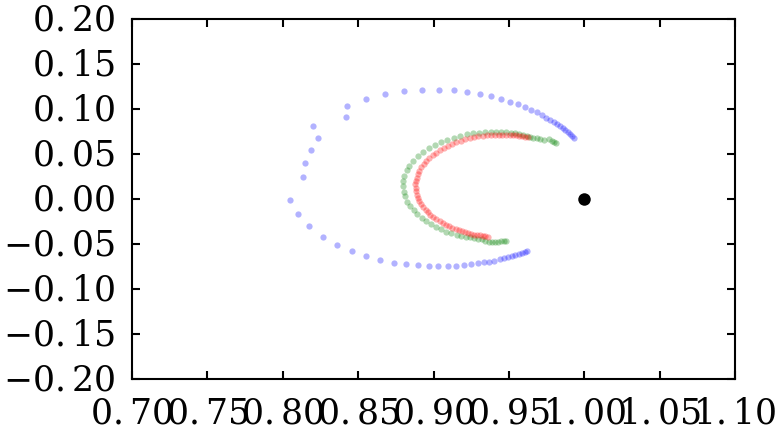

In [12]:
fig, ax = plt.subplots()

ax.plot(0, 0, 'ok')
ax.plot(1, 0, 'ok')
for n, row in df.iterrows():
    ax.plot(row.res_s21_data_normalized.real, row.res_s21_data_normalized.imag, '.', alpha=0.3)
ax.set_xlim(0.7, 1.1)
ax.set_ylim(-0.2, 0.2);

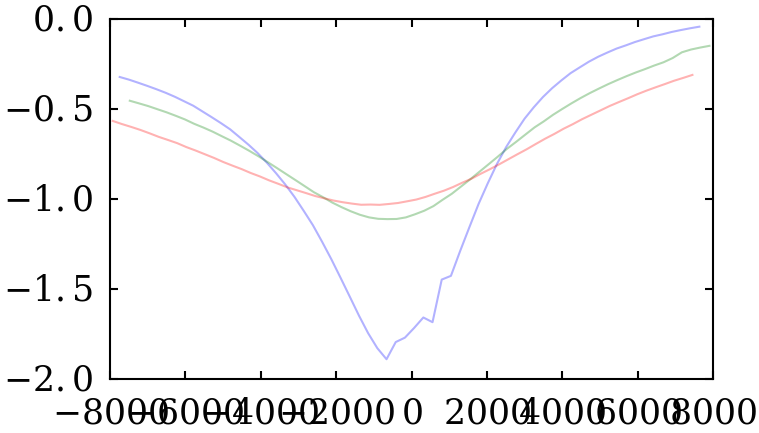

In [13]:
fig, ax = plt.subplots()

for n, row in df.iterrows():
    ax.plot(row.res_frequency_data - row.res_f_0, 20 * np.log10(np.abs(row.res_s21_data_normalized)), '-', alpha=0.3)

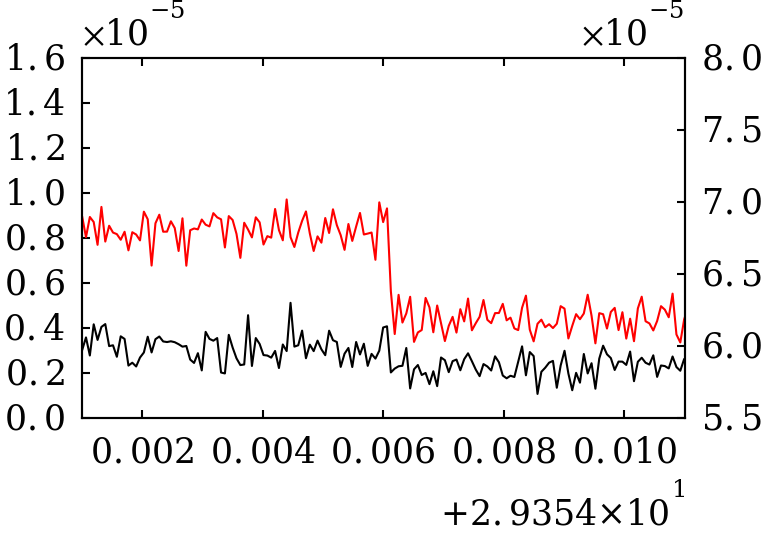

In [14]:
number = 0
sss = ssa[number]

fig, xax = plt.subplots()
qax = xax.twinx()
xax.set_xlim(29.355, 29.365)
qax.plot(sss.stream.sample_time, sss.q, '-r')
xax.plot(sss.stream.sample_time, sss.x, '-k')


# Field-cooling

In [15]:
c155d155 = nc.NCFile(data_directory + '2016-07-20_141430_magnet_array.nc')
c155d85 = nc.NCFile(data_directory + '2016-07-20_155530_magnet_array.nc')
c85d85 = nc.NCFile(data_directory + '2016-07-20_191253_magnet_array.nc')
c85d155 = nc.NCFile(data_directory + '2016-07-20_204043_magnet_array.nc')

In [16]:
c155d155.node_names()

[u'SweepArray0',
 u'SweepStreamArray1',
 u'ADCSnap2',
 u'SweepArray3',
 u'SweepStreamArray4',
 u'ADCSnap5',
 u'SweepArray6',
 u'SweepStreamArray7',
 u'ADCSnap8',
 u'SweepArray9',
 u'SweepStreamArray10',
 u'ADCSnap11',
 u'SweepArray12',
 u'SweepStreamArray13',
 u'ADCSnap14',
 u'SweepArray15',
 u'SweepStreamArray16',
 u'ADCSnap17',
 u'SweepArray18',
 u'SweepStreamArray19',
 u'ADCSnap20']

In [17]:
ssa_c155d155 = c155d155.read('SweepStreamArray13')

In [18]:
ssa_c155d85 = c155d85.read('SweepStreamArray13')

In [19]:
ssa_c85d85 = c85d85.read('SweepStreamArray13')

In [20]:
ssa_c85d155 = c85d155.read('SweepStreamArray13')

In [21]:
df_c155d155 = ssa_c155d155.to_dataframe()

In [22]:
df_c155d85 = ssa_c155d85.to_dataframe()

In [23]:
df_c85d85 = ssa_c85d85.to_dataframe()

In [24]:
df_c85d155 = ssa_c85d155.to_dataframe()

0: 10^6 dx 0.280; 1e6 * diQ_i 0.043
1: 10^6 dx 0.390; 1e6 * diQ_i -0.035
2: 10^6 dx 0.253; 1e6 * diQ_i -0.007


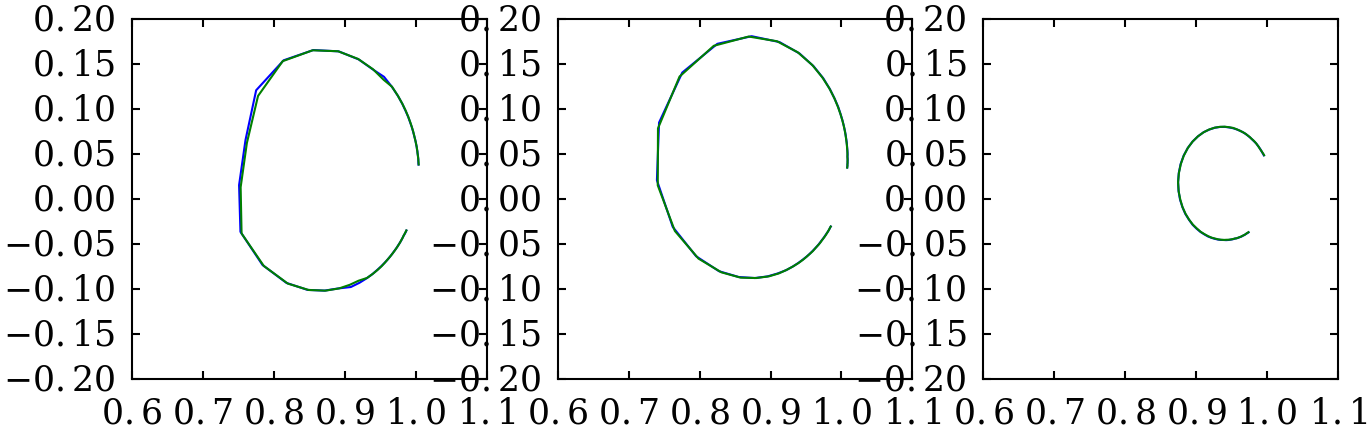

In [25]:
numbers = [0, 1, 2]

fig, axes = plt.subplots(1, 3, figsize=(6, 2))
for number, ax in zip(numbers, axes.flatten()):
    dfa = df_c155d155[df_c155d155.number==number].iloc[0]
    dfb = df_c155d85[df_c155d85.number==number].iloc[0]
    ax.plot(np.array(dfa.res_s21_data_normalized).real,
            np.array(dfa.res_s21_data_normalized).imag)
    ax.plot(np.array(dfb.res_s21_data_normalized).real,
            np.array(dfb.res_s21_data_normalized).imag)
    print("{:d}: 10^6 dx {:.3f}; 1e6 * diQ_i {:.3f}".format(number,
                                                            1e6 * (dfb.res_f_0 / dfa.res_f_0 - 1),
                                                            1e6 * (1 / dfb.res_Q_i - 1 / dfa.res_Q_i)))
    ax.set_xlim(0.6, 1.1)
    ax.set_ylim(-0.2, 0.2)

0: 10^6 dx 0.334; 1e6 * diQ_i -0.035
1: 10^6 dx 0.237; 1e6 * diQ_i 0.039
2: 10^6 dx 0.338; 1e6 * diQ_i -0.042


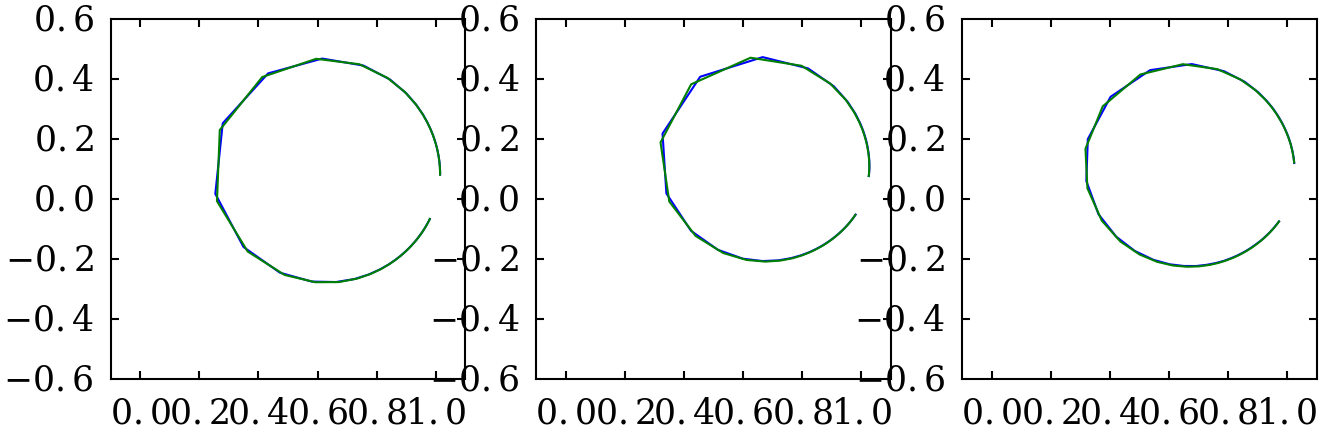

In [26]:
numbers = [0, 1, 2]

fig, axes = plt.subplots(1, 3, figsize=(6, 2))
for number, ax in zip(numbers, axes.flatten()):
    dfa = df_c85d85[df_c85d85.number==number].iloc[0]
    dfb = df_c85d155[df_c85d155.number==number].iloc[0]
    ax.plot(np.array(dfa.res_s21_data_normalized).real,
            np.array(dfa.res_s21_data_normalized).imag)
    ax.plot(np.array(dfb.res_s21_data_normalized).real,
            np.array(dfb.res_s21_data_normalized).imag)
    print("{:d}: 10^6 dx {:.3f}; 1e6 * diQ_i {:.3f}".format(number,
                                                            1e6 * (dfb.res_f_0 / dfa.res_f_0 - 1),
                                                            1e6 * (1 / dfb.res_Q_i - 1 / dfa.res_Q_i)))
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.6, 0.6)